記述統計へのDP適用

In [59]:
!pip install ja-ginza

## 1. 必要なライブラリのインストール

In [60]:
!pip install spacy
!pip install sklearn
!pip install python-dp

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

## 2. データの読み込みと形態素解析


In [61]:
import pandas as pd

data_path = './data/reviews_with_sentiment.csv'

df = pd.read_csv(data_path)
df

,review,sentiment
0,出張でお世話になりました。,neutral
1,朝食は普通でした。,neutral
2,また是非行きたいです。,positive
3,また利用したいと思えるホテルでした。,positive
4,駅から近くて便利でした。,positive
...,...,...
5548,スクランブルエッグにとても大きな殻が入っていてざりざりして気持ちが悪く未だに思い出します。,negative
5549,何組か食事してましたが、明らかにレストランではないスペース。,negative
5550,静かで居心地も良いしまた行きたい宿になりましたが、一点だけ残念だったのが夕食の海鮮舟盛りです。,neutral
5551,チェックインして、部屋に入るとベッドルームの照明の位置もわかりにくく、大変な思いをしました。,negative


In [62]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import itertools
from typing import List, Tuple
from pydp.algorithms.laplacian import Count
import math

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')



# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.0
NUM_VOCAB = 10000
TOP_K = 20

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

def preprocess_for_private_counts(tf: np.ndarray) -> List[np.ndarray]:
    repeated_words = []
    for i, term in enumerate(tf):
        repeated_words.append(np.repeat(i, term))
    return repeated_words

def cal_private_count(epsilon: float, max_partition_contributed: float, max_contributions_per_partition: float, repeated_words: List[np.ndarray]) -> List[int]:
    private_counts = []
    for repeated_word in repeated_words:
        counter = Count(epsilon, max_partition_contributed, max_contributions_per_partition)
        count = counter.quick_result(repeated_word)
        private_counts.append(count)
    return private_counts

def top_k_words_and_counts(k: int, tf: np.ndarray, vocab: dict) -> List[Tuple[str, int]]:
    indices_topk = np.argsort(tf)[::-1][:k]
    reverse_vocab = {vocab[key]: key for key in vocab.keys()}
    words = [reverse_vocab[i] for i in indices_topk]
    counts = [tf[i] for i in indices_topk]
    return list(zip(words, counts))
# 形態素解析
df["doc"] = [nlp(review) for review in df["review"]]

## 3. Bag-of-Wordsの生成

In [63]:
# Bag-of-Wordsの生成
bows = {}
cvs = {}

for sentiment in df["sentiment"].unique():
    tokens = []
    for doc in df[df["sentiment"] == sentiment]["doc"]:
        similarities = [(token.similarity(doc), token.lemma_) for token in doc if token.pos_ in POS]
        similarities = remove_duplicates(similarities)
        similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
        tokens.append([similarity[1] for similarity in similarities])
    
    cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
    bows[sentiment] = cv.fit_transform(flatten(tokens)).toarray()
    cvs[sentiment] = cv

/tmp/ipykernel_931337/2647833454.py:8: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(doc), token.lemma_) for token in doc if token.pos_ in POS]


In [64]:
!pip install numpy
!pip install matplotlib
!pip install seaborn

## 4. 上位単語の頻度を計算

In [65]:
# 上位単語の頻度を計算
vocabs = {}
term_frequencies = {}

for sentiment in df["sentiment"].unique():
    bow = bows[sentiment]
    cv = cvs[sentiment]
    
    vocab = cv.vocabulary_
    term_frequency = np.sum(bow, axis=0)
    vocabs[sentiment] = vocab
    term_frequencies[sentiment] = term_frequency
    
    indices_topk = np.argsort(term_frequency)[::-1][:TOP_K]
    bow_topk = np.take(bow, indices_topk, axis=1)
    reverse_vocab = {vocab[k]: k for k in vocab.keys()}
    words = [reverse_vocab[i] for i in indices_topk]
    
    print(sentiment, ":")
    for w, c in zip(words, term_frequency[indices_topk]):
        print(w, ":", c)


neutral :
利用 : 216
部屋 : 93
旅行 : 67
ある : 60
思う : 59
朝食 : 50
風呂 : 47
普通 : 45
宿泊 : 43
なる : 43
初めて : 34
ホテル : 32
いる : 30
良い : 27
感じ : 27
家族 : 25
出張 : 25
予約 : 23
する : 22
夕食 : 21
positive :
良い : 463
部屋 : 315
美味しい : 206
利用 : 198
満足 : 193
朝食 : 181
思う : 175
ある : 144
風呂 : 141
最高 : 140
ホテル : 124
対応 : 106
いる : 102
また : 99
温泉 : 96
清潔 : 90
よい : 90
接客 : 87
綺麗 : 84
気持ち : 80
negative :
残念 : 99
部屋 : 97
少し : 48
風呂 : 42
朝食 : 39
狭い : 36
思う : 34
ある : 33
ない : 27
良い : 24
なる : 22
悪い : 19
欲しい : 16
する : 16
露天風呂 : 16
古い : 16
掃除 : 15
食べる : 15
食事 : 15
改善 : 14


## 5. 差分プライバシーの適用


ε:  0.01


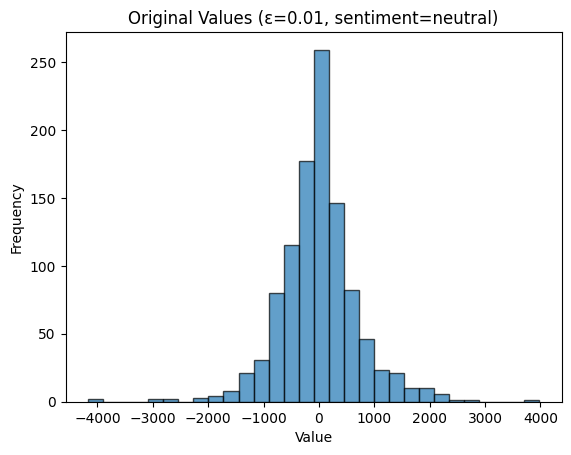

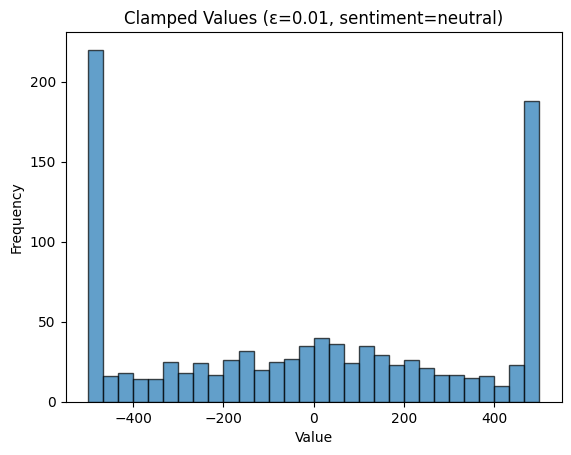

neutral :
[('素泊まり', 4.975083125415949), ('高齢', 4.975083125415949), ('実家', 4.975083125415949), ('見つける', 4.975083125415949), ('家族風呂', 4.975083125415949), ('見える', 4.975083125415949), ('宿泊', 4.975083125415949), ('宿泊施設', 4.975083125415949), ('沈む', 4.975083125415949), ('泊まれる', 4.975083125415949), ('行く', 4.975083125415949), ('下調べ', 4.975083125415949), ('和食', 4.975083125415949), ('和洋', 4.975083125415949), ('寝る', 4.975083125415949), ('忘れる', 4.975083125415949), ('若干', 4.975083125415949), ('ポイント', 4.975083125415949), ('なぜ', 4.975083125415949), ('なり', 4.975083125415949)]


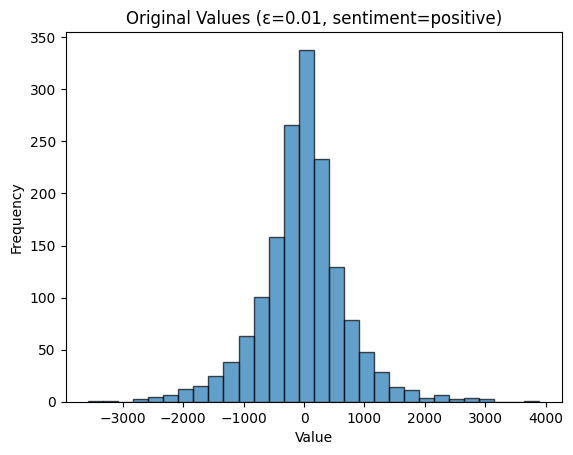

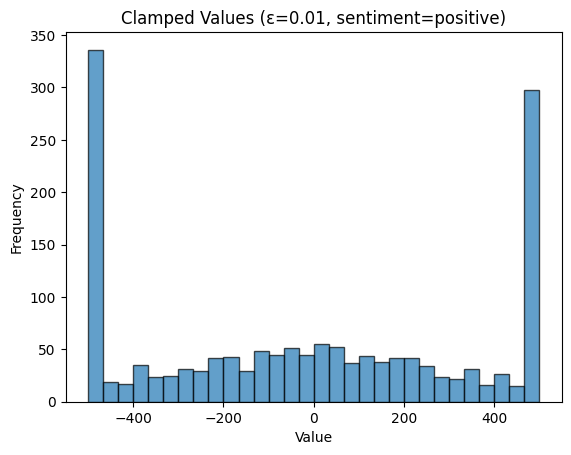

positive :
[('無い', 4.975083125415949), ('懸念', 4.975083125415949), ('懐かしい', 4.975083125415949), ('落ち着ける', 4.975083125415949), ('慣れる', 4.975083125415949), ('感謝', 4.975083125415949), ('感覚', 4.975083125415949), ('みな', 4.975083125415949), ('感服', 4.975083125415949), ('代わり', 4.975083125415949), ('まだ', 4.975083125415949), ('行く', 4.975083125415949), ('行列', 4.975083125415949), ('街中', 4.975083125415949), ('衣装', 4.975083125415949), ('補う', 4.975083125415949), ('愛煙家', 4.975083125415949), ('以前', 4.975083125415949), ('見える', 4.975083125415949), ('見せる', 4.975083125415949)]


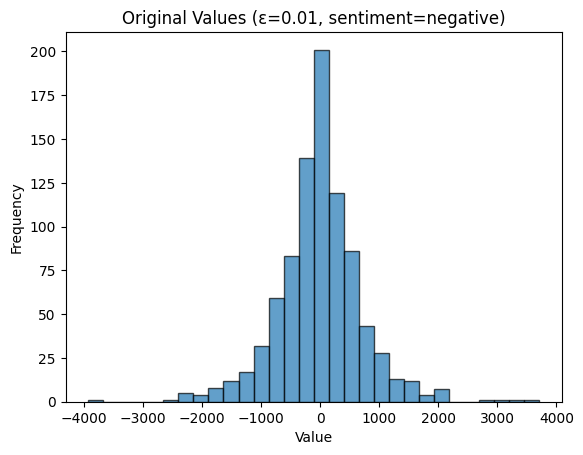

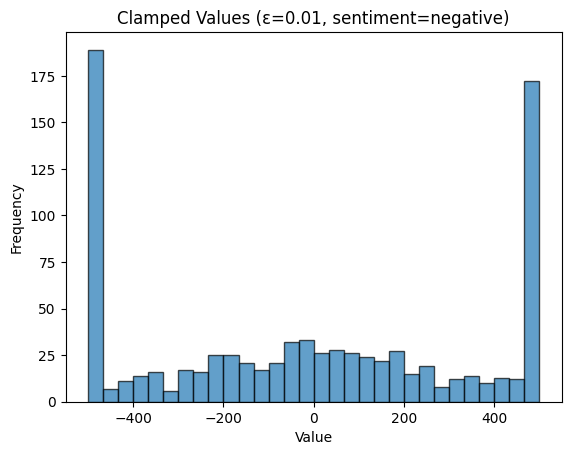

negative :
[('黒い', 4.975083125415949), ('有る', 4.975083125415949), ('娘婿', 4.975083125415949), ('子ども', 4.975083125415949), ('終わる', 4.975083125415949), ('紹介', 4.975083125415949), ('せっかく', 4.975083125415949), ('精算機', 4.975083125415949), ('定番', 4.975083125415949), ('笑顔', 4.975083125415949), ('宿代', 4.975083125415949), ('宿泊料', 4.975083125415949), ('立つ', 4.975083125415949), ('寝る', 4.975083125415949), ('対応', 4.975083125415949), ('空気清浄機', 4.975083125415949), ('小さい', 4.975083125415949), ('小さめ', 4.975083125415949), ('コンセント', 4.975083125415949), ('展望', 4.975083125415949)]
ε:  0.05


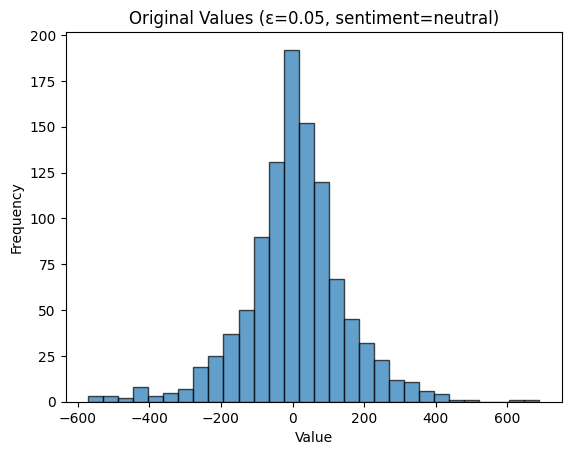

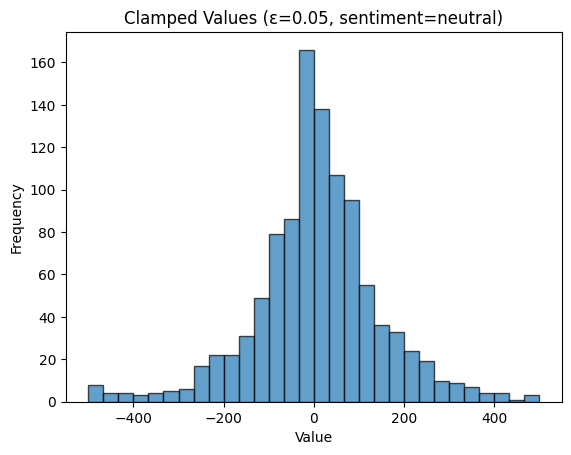

neutral :
[('夜鳴きそば', 24.385287749643), ('別館', 24.385287749643), ('そして', 24.385287749643), ('空港', -32.614712250357), ('年末年始', -42.614712250357), ('疑問', -57.614712250357), ('覚える', -59.614712250357), ('分かる', -72.614712250357), ('初め', -91.614712250357), ('最後', -92.614712250357), ('内容', -99.614712250357), ('無難', -108.614712250357), ('出来る', -119.614712250357), ('キッザニア', -119.614712250357), ('建て', -123.614712250357), ('広め', -126.614712250357), ('天気', -135.614712250357), ('過ぎ', -135.614712250357), ('タイトル', -140.614712250357), ('ぬるい', -149.614712250357)]


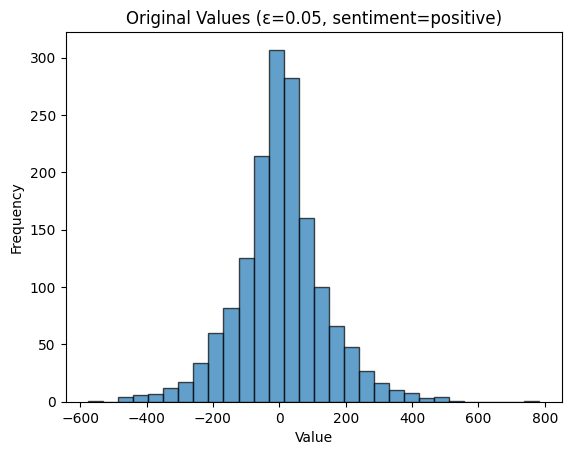

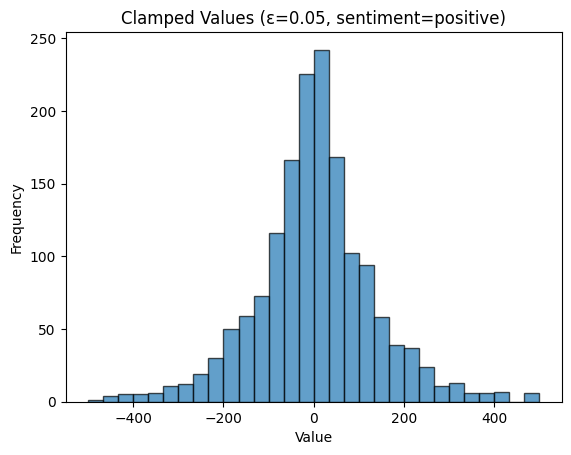

positive :
[('結果', 24.385287749643), ('寝心地', 24.385287749643), ('断然', 24.385287749643), ('繁華街', 14.385287749642998), ('マイナス', 14.385287749642998), ('到着時間', -3.6147122503570017), ('寒い', -42.614712250357), ('ベビーフェイス', -42.614712250357), ('入浴', -49.614712250357), ('満足', -59.614712250357), ('良い', -66.614712250357), ('地下', -67.614712250357), ('クロワッサン', -73.614712250357), ('半蔵門線', -78.614712250357), ('ステーキ', -84.614712250357), ('離れる', -89.614712250357), ('嵐山', -98.614712250357), ('色々', -100.614712250357), ('線路', -100.614712250357), ('見える', -109.614712250357)]


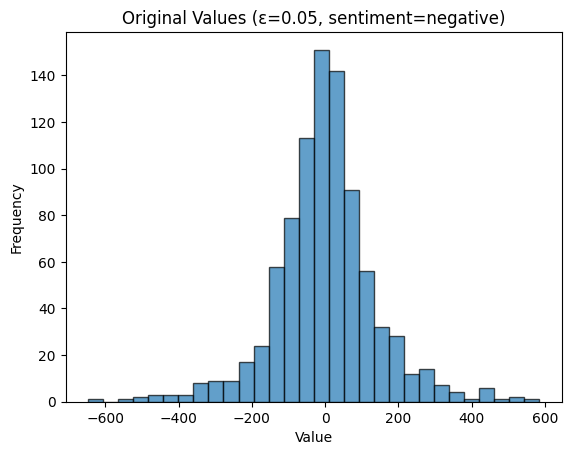

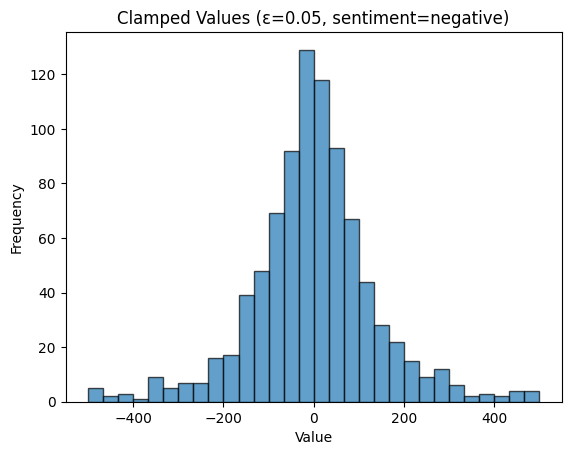

negative :
[('マンション', 24.385287749643), ('遠い', 24.385287749643), ('建物', 24.385287749643), ('捨てる', 24.385287749643), ('ウォシュレット', -20.614712250357), ('楽しみ', -24.614712250357), ('ポン', -29.614712250357), ('風呂場', -31.614712250357), ('カーテン', -45.614712250357), ('少ない', -46.614712250357), ('長旅', -93.614712250357), ('スマホ', -105.614712250357), ('瞬間', -107.614712250357), ('運転手', -127.614712250357), ('眠れる', -131.614712250357), ('助かる', -145.614712250357), ('薄い', -146.614712250357), ('セルフ', -152.614712250357), ('危ない', -152.614712250357), ('多め', -169.614712250357)]
ε:  0.1


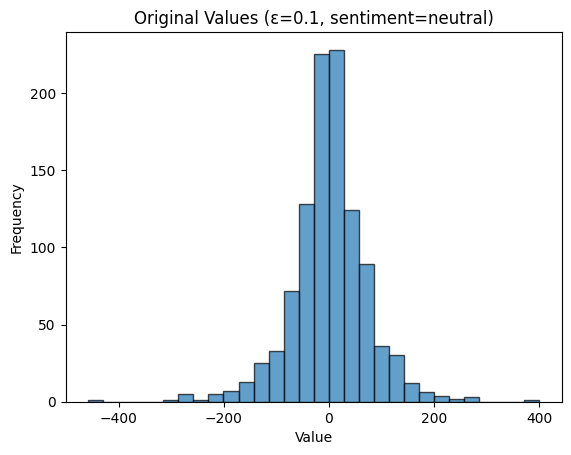

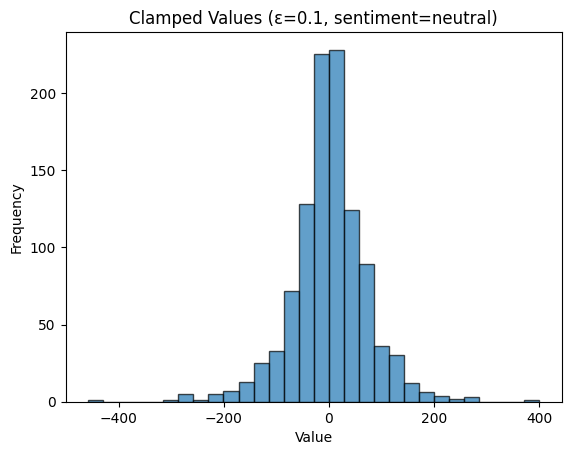

neutral :
[('風呂', -52.41870901797978), ('誕生日', -170.41870901797978), ('まあ', -173.41870901797978), ('感ずる', -178.41870901797978), ('利用', -222.41870901797978), ('提供', -223.41870901797978), ('部屋', -227.41870901797978), ('強いて', -229.41870901797978), ('ビックリ', -238.41870901797978), ('ハイシーズン', -243.41870901797978), ('スイッチ', -256.4187090179798), ('アイスコーヒー', -258.4187090179798), ('ネット', -267.4187090179798), ('向く', -277.4187090179798), ('赤ちゃん', -277.4187090179798), ('タバコ', -279.4187090179798), ('宿泊', -284.4187090179798), ('常々', -284.4187090179798), ('シャトルバス', -290.4187090179798), ('ポイント', -293.4187090179798)]


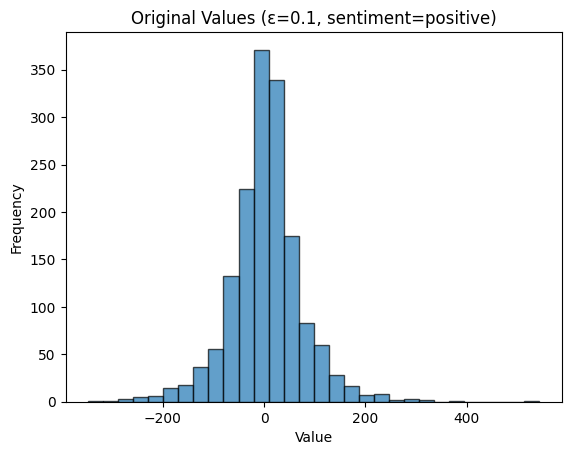

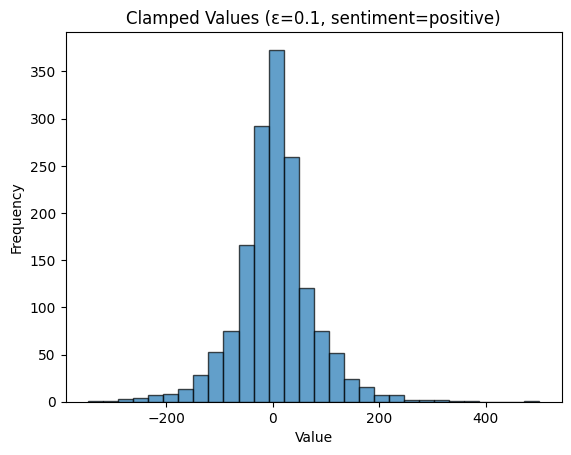

positive :
[('良い', 47.58129098202022), ('近隣', -80.41870901797978), ('条件', -121.41870901797978), ('部屋', -132.41870901797978), ('夏休み', -149.41870901797978), ('選び', -156.41870901797978), ('家族', -173.41870901797978), ('夫婦', -199.41870901797978), ('嵐山', -203.41870901797978), ('利用', -209.41870901797978), ('ありがとう', -214.41870901797978), ('名物', -220.41870901797978), ('ギリギリ', -220.41870901797978), ('満足', -220.41870901797978), ('奈良', -221.41870901797978), ('腎臓', -227.41870901797978), ('思う', -235.41870901797978), ('温水', -242.41870901797978), ('スキー', -247.41870901797978), ('朝食', -247.41870901797978)]


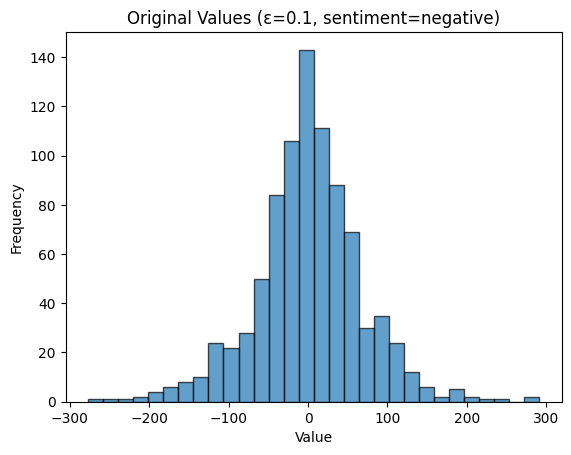

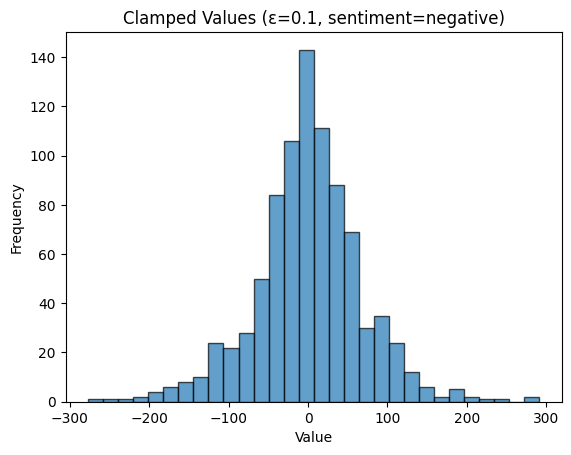

negative :
[('コスパ', -161.41870901797978), ('セキュリティー', -177.41870901797978), ('予約', -213.41870901797978), ('時間', -224.41870901797978), ('運転', -239.41870901797978), ('宿泊', -252.41870901797978), ('度目', -258.4187090179798), ('駄目', -259.4187090179798), ('自分', -260.4187090179798), ('もう', -264.4187090179798), ('移動', -266.4187090179798), ('本当', -275.4187090179798), ('電車', -282.4187090179798), ('最近', -296.4187090179798), ('失敗', -297.4187090179798), ('自体', -299.4187090179798), ('残念', -307.4187090179798), ('歯磨き', -309.4187090179798), ('添い寝', -311.4187090179798), ('若い', -313.4187090179798)]
ε:  0.3


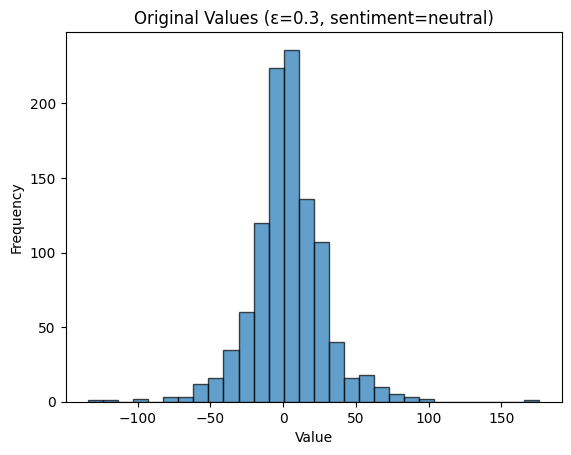

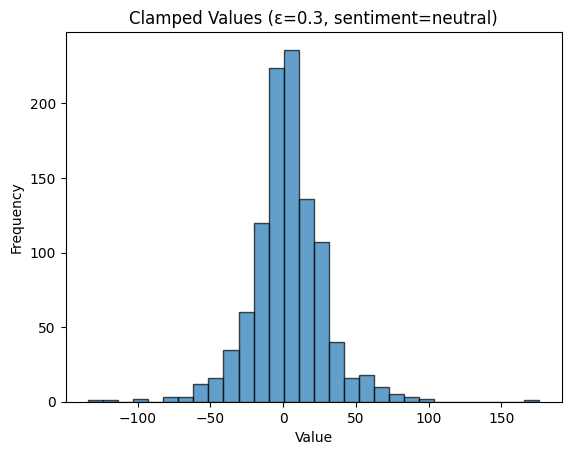

neutral :
[('利用', -194.40911034085894), ('匂い', -269.40911034085894), ('転倒', -275.40911034085894), ('出張', -280.40911034085894), ('部屋', -280.40911034085894), ('スタイル', -283.40911034085894), ('バスターミナル', -288.40911034085894), ('見る', -289.40911034085894), ('まあまあ', -290.40911034085894), ('道後温泉', -290.40911034085894), ('良く', -291.40911034085894), ('具合', -298.40911034085894), ('分れる', -298.40911034085894), ('沈む', -299.40911034085894), ('問題', -300.40911034085894), ('あり', -301.40911034085894), ('旅行', -301.40911034085894), ('思う', -302.40911034085894), ('高岡駅', -302.40911034085894), ('天気', -303.40911034085894)]


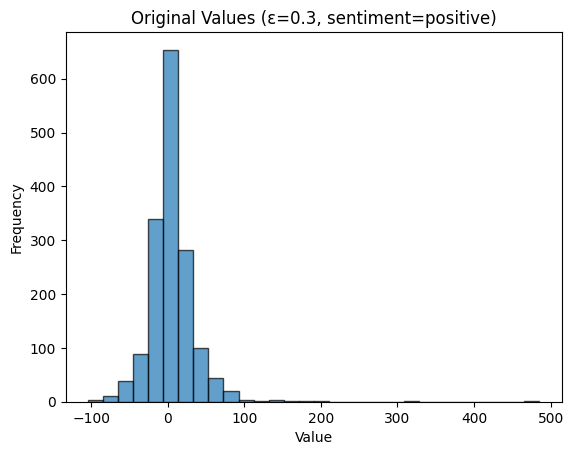

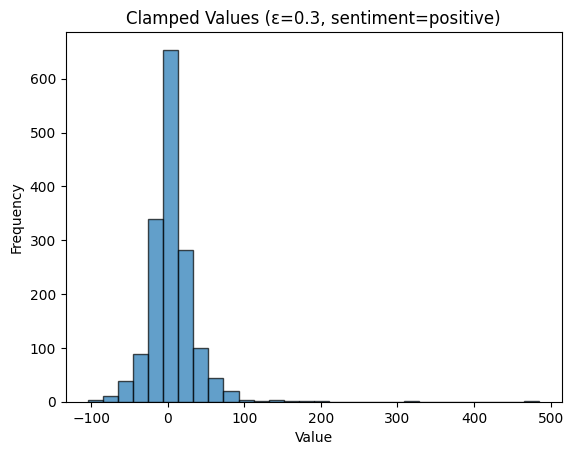

positive :
[('良い', 114.59088965914106), ('部屋', -54.409110340858945), ('美味しい', -160.40911034085894), ('利用', -172.40911034085894), ('思う', -190.40911034085894), ('満足', -194.40911034085894), ('ある', -207.40911034085894), ('朝食', -212.40911034085894), ('対応', -231.40911034085894), ('最高', -235.40911034085894), ('風呂', -238.40911034085894), ('ホテル', -254.40911034085894), ('広い', -266.40911034085894), ('快適', -269.40911034085894), ('痒い', -275.40911034085894), ('お奨め', -277.40911034085894), ('行く', -279.40911034085894), ('また', -280.40911034085894), ('感じ', -280.40911034085894), ('素晴らしい', -283.40911034085894)]


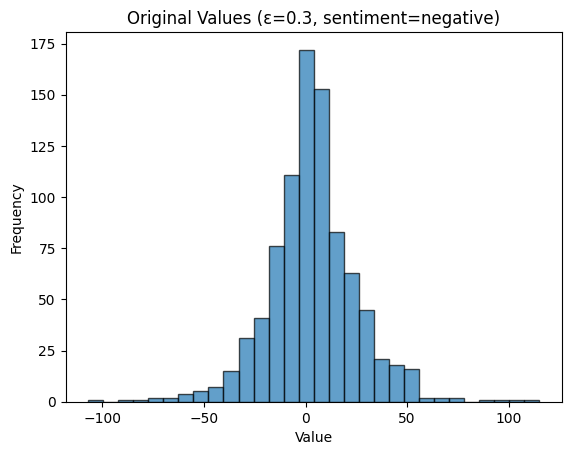

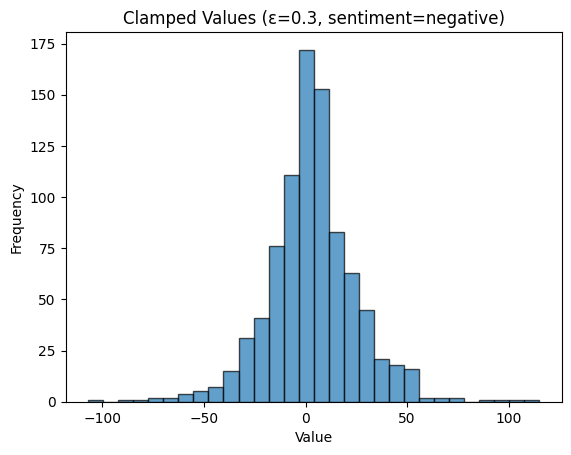

negative :
[('暖かい', -255.40911034085894), ('部屋', -264.40911034085894), ('翌朝', -271.40911034085894), ('駐車場', -279.40911034085894), ('開ける', -293.40911034085894), ('残念', -297.40911034085894), ('寂しい', -300.40911034085894), ('ひどい', -301.40911034085894), ('歩かす', -308.40911034085894), ('使用', -313.40911034085894), ('汚れ', -315.40911034085894), ('ソフトクリーム', -316.40911034085894), ('思う', -316.40911034085894), ('隅々', -316.40911034085894), ('スライダー', -316.40911034085894), ('非常', -317.40911034085894), ('閉じる', -318.40911034085894), ('かわいそう', -319.40911034085894), ('空気清浄機', -319.40911034085894), ('行く', -320.40911034085894)]
ε:  0.7


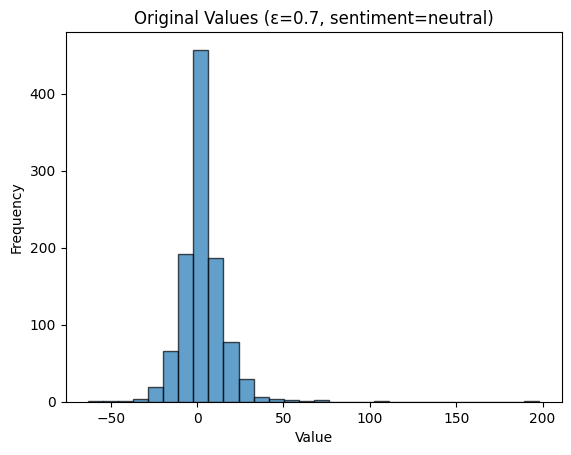

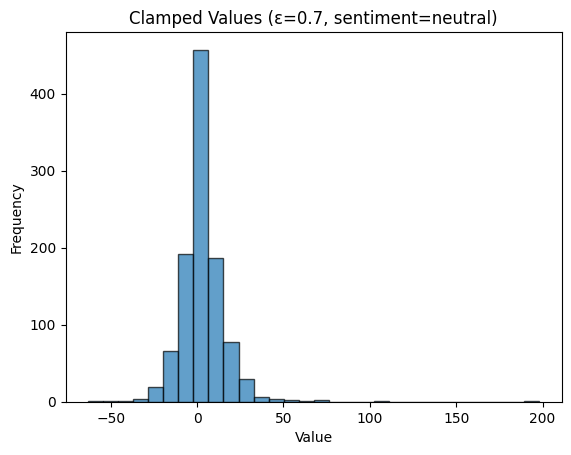

neutral :
[('利用', -50.29265189570475), ('部屋', -141.29265189570475), ('朝食', -178.29265189570475), ('旅行', -179.29265189570475), ('思う', -187.29265189570475), ('ある', -190.29265189570475), ('風呂', -195.29265189570475), ('宿泊', -198.29265189570475), ('なる', -203.29265189570475), ('プラン', -205.29265189570475), ('守る', -208.29265189570475), ('混雑', -209.29265189570475), ('普通', -211.29265189570475), ('ビジネスホテル', -213.29265189570475), ('土産', -213.29265189570475), ('家族', -215.29265189570475), ('伝統', -216.29265189570475), ('季節', -217.29265189570475), ('お世話', -217.29265189570475), ('機械', -217.29265189570475)]


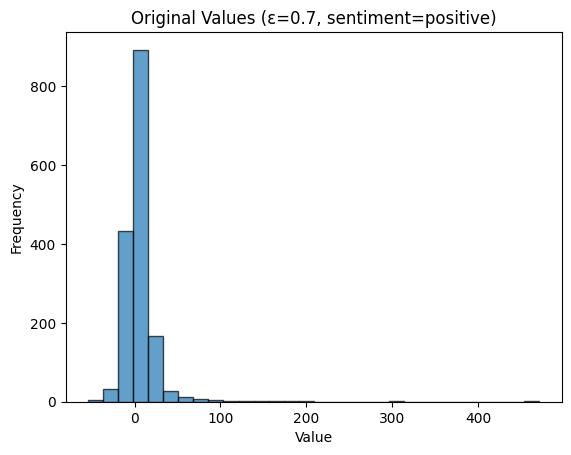

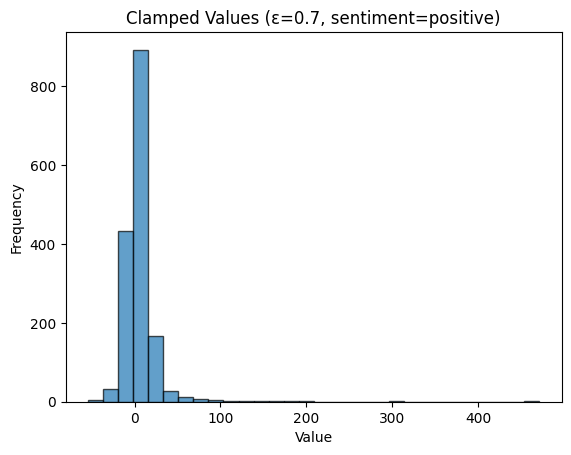

positive :
[('良い', 222.70734810429525), ('部屋', 63.70734810429525), ('美味しい', -42.29265189570475), ('利用', -54.29265189570475), ('朝食', -64.29265189570475), ('思う', -69.29265189570475), ('満足', -75.29265189570475), ('ある', -86.29265189570475), ('最高', -98.29265189570475), ('風呂', -108.29265189570475), ('ホテル', -122.29265189570475), ('いる', -137.29265189570475), ('対応', -142.29265189570475), ('温泉', -142.29265189570475), ('快適', -149.29265189570475), ('また', -150.29265189570475), ('よい', -151.29265189570475), ('綺麗', -161.29265189570475), ('清潔', -163.29265189570475), ('気持ち', -165.29265189570475)]


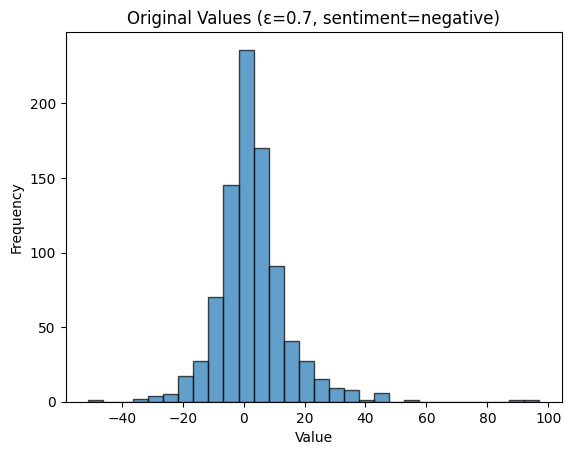

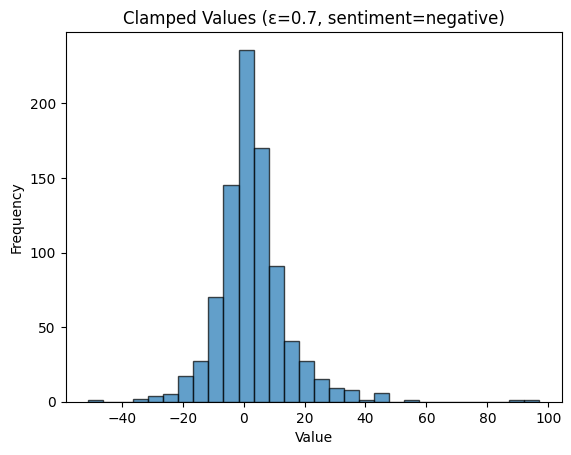

negative :
[('部屋', -151.29265189570475), ('残念', -158.29265189570475), ('少し', -192.29265189570475), ('業務', -202.29265189570475), ('直後', -203.29265189570475), ('利用', -203.29265189570475), ('注意', -204.29265189570475), ('立地', -204.29265189570475), ('ない', -205.29265189570475), ('狭い', -209.29265189570475), ('謝罪', -211.29265189570475), ('一人', -211.29265189570475), ('風呂', -212.29265189570475), ('近く', -213.29265189570475), ('配膳', -213.29265189570475), ('すごい', -214.29265189570475), ('思う', -214.29265189570475), ('朝食', -214.29265189570475), ('タオル', -216.29265189570475), ('沼津', -217.29265189570475)]
ε:  1.0


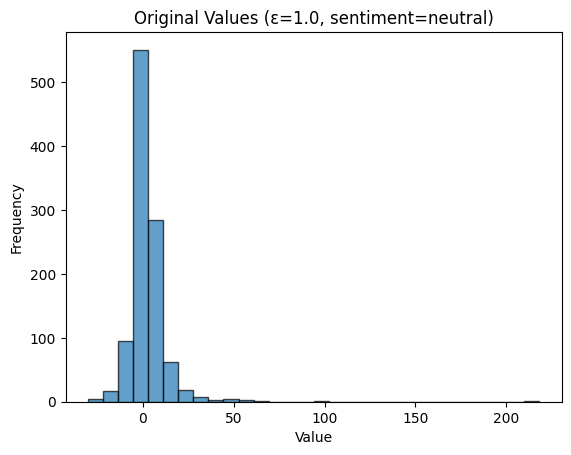

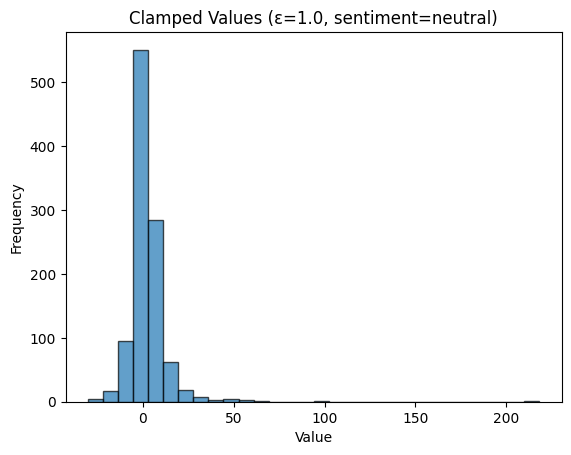

neutral :
[('利用', 34.060279414278824), ('部屋', -86.93972058572118), ('旅行', -116.93972058572118), ('思う', -126.93972058572118), ('ある', -126.93972058572118), ('初めて', -132.93972058572118), ('風呂', -134.93972058572118), ('なる', -135.93972058572118), ('朝食', -138.93972058572118), ('いる', -140.93972058572118), ('出張', -141.93972058572118), ('家族', -146.93972058572118), ('普通', -151.93972058572118), ('疑問', -151.93972058572118), ('ホテル', -151.93972058572118), ('良い', -153.93972058572118), ('宿泊', -153.93972058572118), ('温泉', -154.93972058572118), ('夕食', -155.93972058572118), ('手足', -156.93972058572118)]


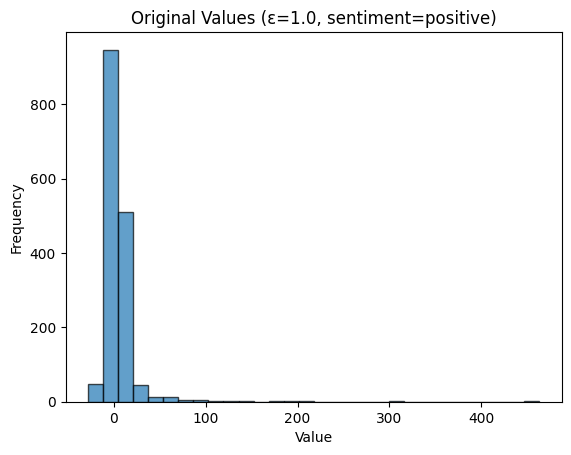

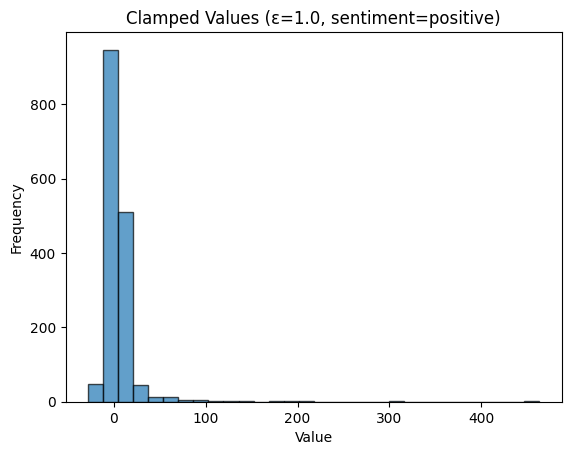

positive :
[('良い', 279.06027941427885), ('部屋', 122.06027941427882), ('利用', 32.060279414278824), ('美味しい', 24.060279414278824), ('満足', 9.060279414278824), ('朝食', -2.939720585721176), ('思う', -10.939720585721176), ('ある', -41.939720585721176), ('最高', -43.939720585721176), ('風呂', -49.939720585721176), ('ホテル', -54.939720585721176), ('対応', -75.93972058572118), ('いる', -78.93972058572118), ('また', -84.93972058572118), ('清潔', -87.93972058572118), ('よい', -92.93972058572118), ('綺麗', -92.93972058572118), ('温泉', -95.93972058572118), ('接客', -97.93972058572118), ('広い', -102.93972058572118)]


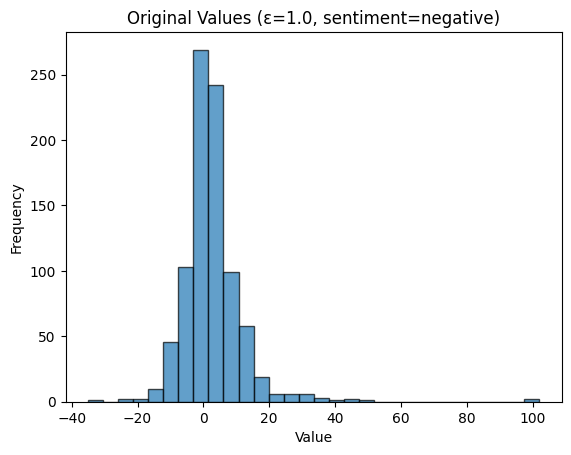

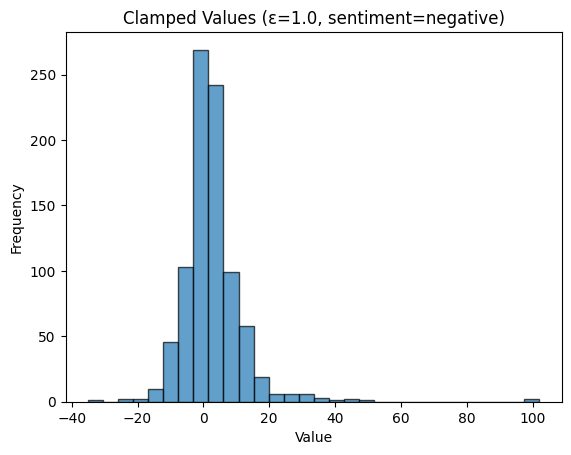

negative :
[('残念', -81.93972058572118), ('部屋', -82.93972058572118), ('風呂', -133.93972058572118), ('朝食', -138.93972058572118), ('少し', -139.93972058572118), ('狭い', -144.93972058572118), ('温まる', -145.93972058572118), ('思う', -146.93972058572118), ('食事時間', -149.93972058572118), ('ある', -151.93972058572118), ('ない', -151.93972058572118), ('清潔', -151.93972058572118), ('なる', -152.93972058572118), ('入れる', -153.93972058572118), ('温度', -154.93972058572118), ('修繕', -155.93972058572118), ('枕元', -155.93972058572118), ('刺す', -157.93972058572118), ('感ずる', -157.93972058572118), ('無くなる', -158.93972058572118)]
ε:  2.0


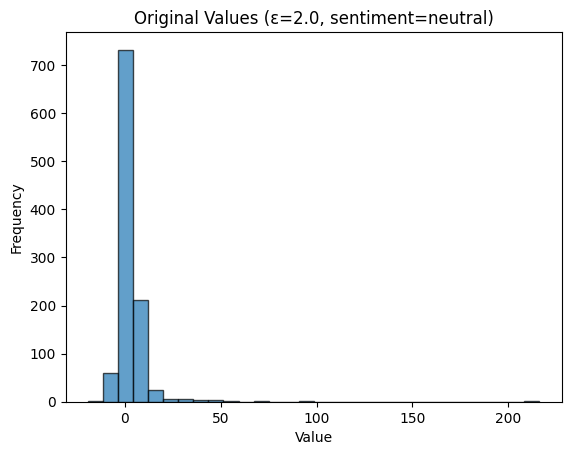

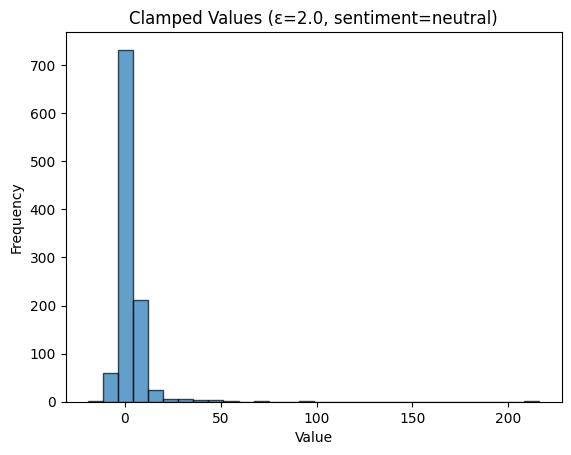

neutral :
[('利用', 148.33235838169367), ('部屋', 23.332358381693652), ('旅行', 0.33235838169365195), ('思う', -9.667641618306348), ('ある', -12.667641618306348), ('朝食', -17.667641618306348), ('風呂', -19.667641618306348), ('宿泊', -23.667641618306348), ('普通', -24.667641618306348), ('初めて', -31.667641618306348), ('なる', -31.667641618306348), ('ホテル', -34.66764161830635), ('出張', -37.66764161830635), ('良い', -38.66764161830635), ('いる', -38.66764161830635), ('感じ', -39.66764161830635), ('行く', -41.66764161830635), ('家族', -42.66764161830635), ('ない', -43.66764161830635), ('温泉', -43.66764161830635)]


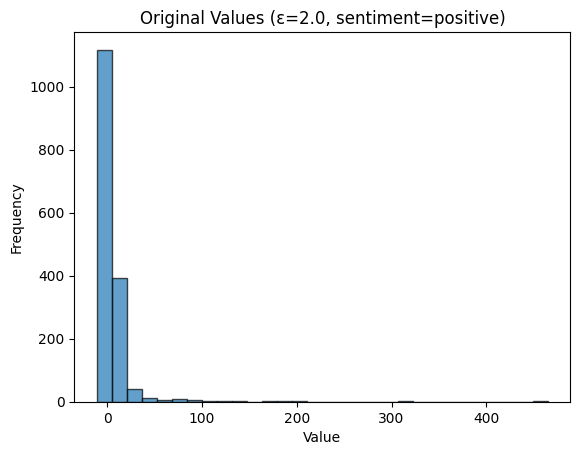

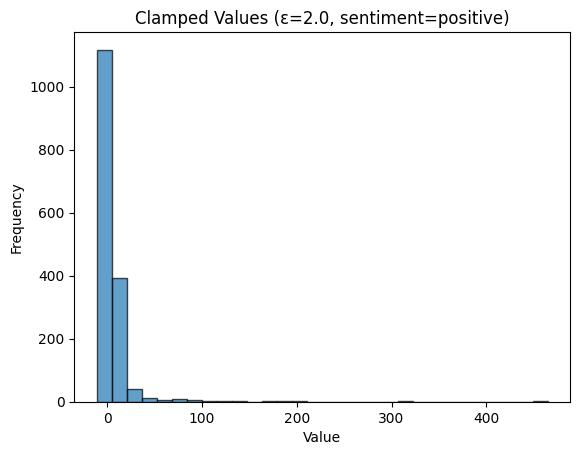

positive :
[('良い', 397.33235838169367), ('部屋', 250.33235838169367), ('美味しい', 138.33235838169367), ('利用', 130.33235838169367), ('満足', 124.33235838169365), ('朝食', 119.33235838169365), ('思う', 110.33235838169365), ('ある', 79.33235838169365), ('最高', 72.33235838169365), ('風呂', 66.33235838169365), ('ホテル', 53.33235838169365), ('対応', 40.33235838169365), ('いる', 35.33235838169365), ('温泉', 31.332358381693652), ('また', 29.332358381693652), ('よい', 21.332358381693652), ('清潔', 20.332358381693652), ('広い', 19.332358381693652), ('接客', 18.332358381693652), ('行く', 12.332358381693652)]


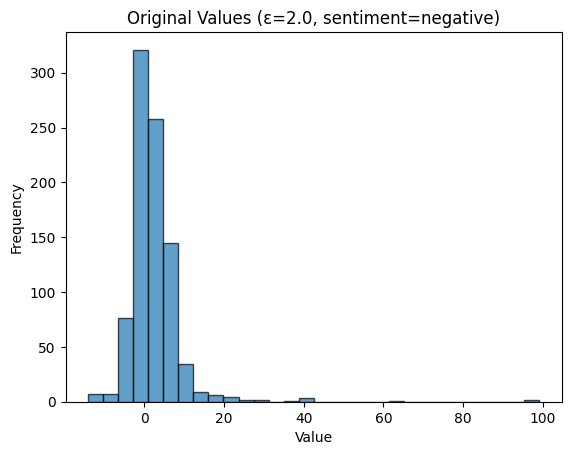

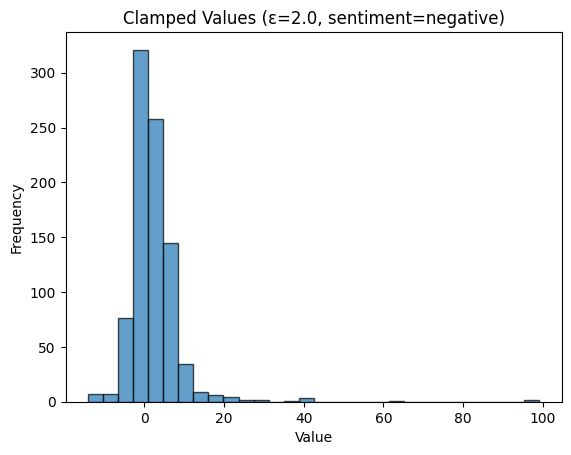

negative :
[('残念', 31.332358381693652), ('部屋', 29.332358381693652), ('少し', -4.667641618306348), ('風呂', -25.667641618306348), ('朝食', -25.667641618306348), ('狭い', -26.667641618306348), ('ある', -32.66764161830635), ('思う', -36.66764161830635), ('ない', -38.66764161830635), ('良い', -42.66764161830635), ('なる', -42.66764161830635), ('古い', -44.66764161830635), ('感ずる', -45.66764161830635), ('無い', -46.66764161830635), ('露天風呂', -47.66764161830635), ('欲しい', -48.66764161830635), ('掃除', -48.66764161830635), ('改善', -49.66764161830635), ('遠い', -50.66764161830635), ('食事', -50.66764161830635)]
ε:  3.0


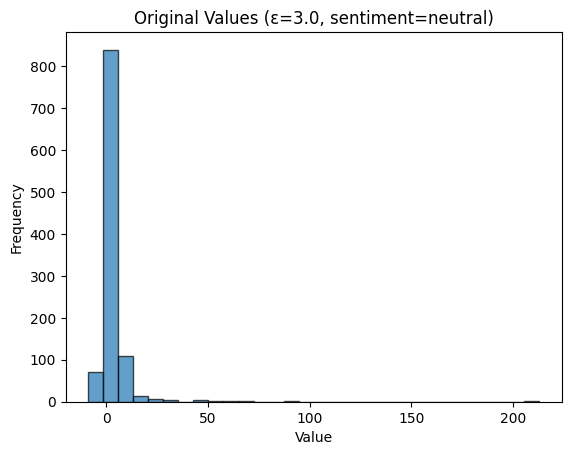

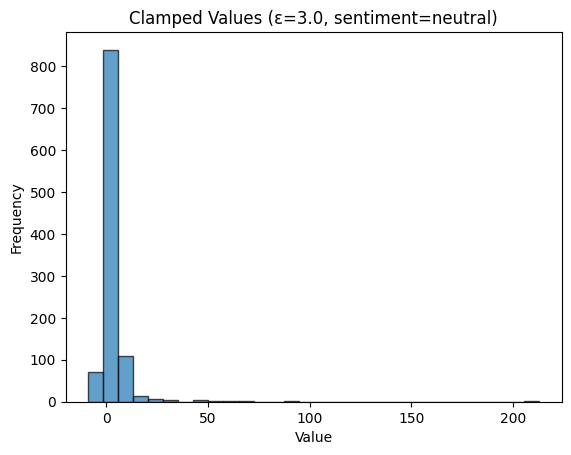

neutral :
[('利用', 188.10646581606804), ('部屋', 69.10646581606802), ('旅行', 42.106465816068024), ('ある', 35.106465816068024), ('思う', 33.106465816068024), ('朝食', 26.106465816068027), ('風呂', 26.106465816068027), ('普通', 20.106465816068027), ('宿泊', 18.106465816068027), ('なる', 18.106465816068027), ('初めて', 9.106465816068027), ('ホテル', 7.106465816068027), ('いる', 5.106465816068027), ('良い', 4.106465816068027), ('予約', 2.1064658160680274), ('感じ', 0.10646581606802741), ('出張', 0.10646581606802741), ('家族', -2.8935341839319726), ('する', -2.8935341839319726), ('温泉', -3.8935341839319726)]


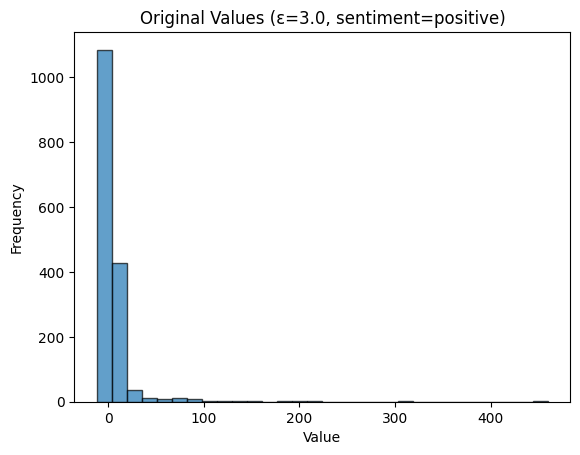

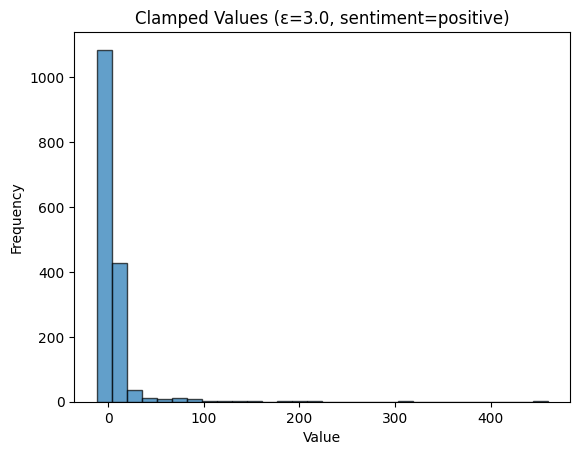

positive :
[('良い', 435.106465816068), ('部屋', 291.106465816068), ('美味しい', 186.10646581606804), ('利用', 175.10646581606804), ('満足', 169.10646581606804), ('朝食', 156.10646581606804), ('思う', 152.10646581606804), ('風呂', 121.10646581606802), ('ある', 118.10646581606802), ('最高', 111.10646581606802), ('ホテル', 99.10646581606802), ('対応', 78.10646581606802), ('また', 73.10646581606802), ('いる', 73.10646581606802), ('温泉', 72.10646581606802), ('よい', 65.10646581606802), ('清潔', 64.10646581606802), ('綺麗', 64.10646581606802), ('接客', 62.106465816068024), ('気持ち', 57.106465816068024)]


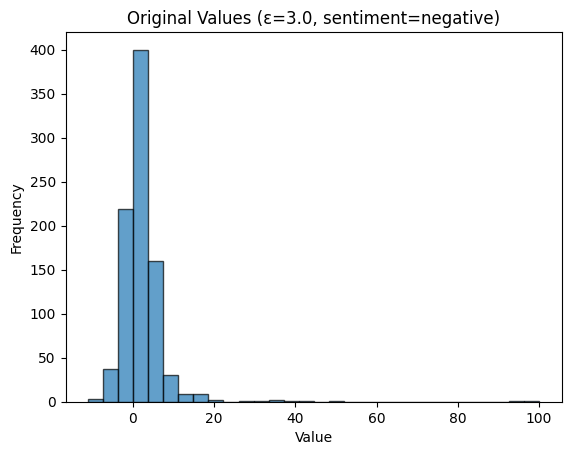

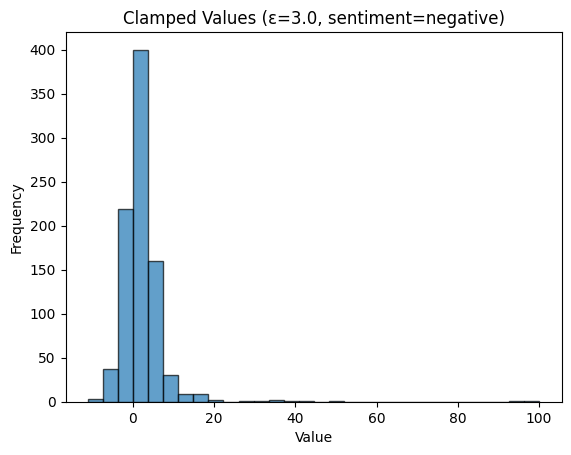

negative :
[('残念', 75.10646581606802), ('部屋', 71.10646581606802), ('少し', 26.106465816068027), ('風呂', 16.106465816068027), ('朝食', 14.106465816068027), ('思う', 11.106465816068027), ('狭い', 10.106465816068027), ('ある', 8.106465816068027), ('ない', 2.1064658160680274), ('良い', -2.8935341839319726), ('なる', -5.893534183931973), ('悪い', -6.893534183931973), ('遠い', -6.893534183931973), ('露天風呂', -7.893534183931973), ('する', -7.893534183931973), ('欲しい', -8.893534183931973), ('古い', -9.893534183931973), ('無い', -9.893534183931973), ('掃除', -9.893534183931973), ('食事', -9.893534183931973)]
ε:  7.0


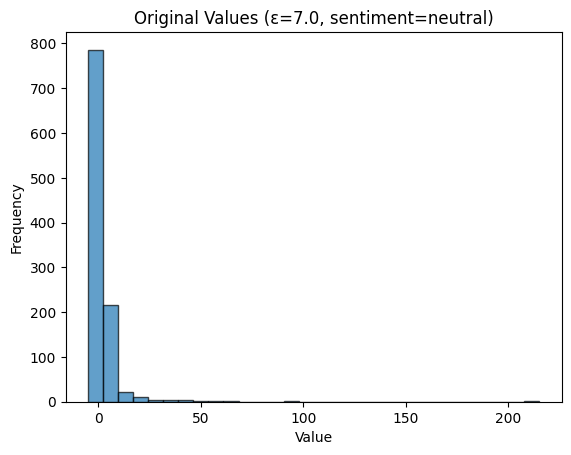

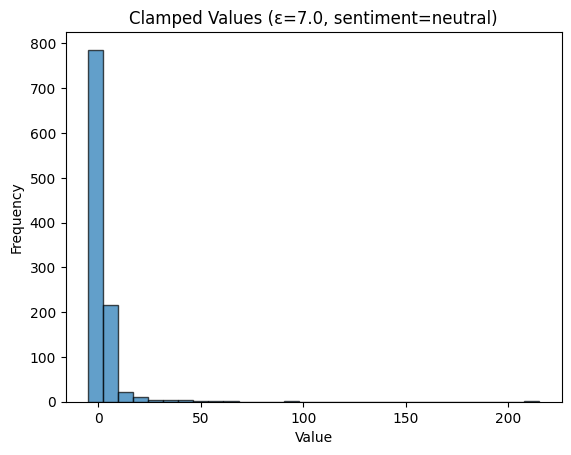

neutral :
[('利用', 214.54405901722274), ('部屋', 93.54405901722274), ('旅行', 65.54405901722274), ('ある', 60.54405901722274), ('思う', 58.54405901722274), ('朝食', 49.54405901722274), ('普通', 46.54405901722274), ('風呂', 45.54405901722274), ('宿泊', 43.54405901722274), ('なる', 42.54405901722274), ('初めて', 33.54405901722274), ('ホテル', 32.54405901722274), ('いる', 32.54405901722274), ('良い', 26.544059017222743), ('感じ', 25.544059017222743), ('出張', 24.544059017222743), ('家族', 24.544059017222743), ('ない', 21.544059017222743), ('夕食', 21.544059017222743), ('予約', 21.544059017222743)]


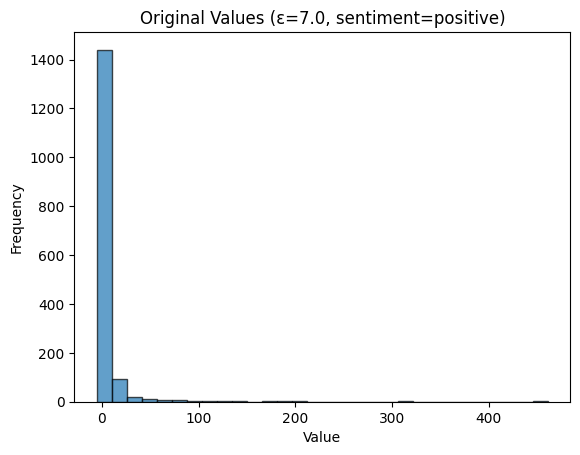

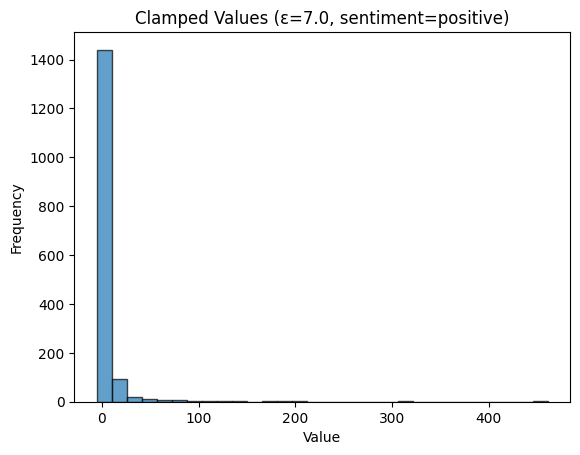

positive :
[('良い', 460.54405901722276), ('部屋', 315.54405901722276), ('美味しい', 205.54405901722274), ('利用', 199.54405901722274), ('満足', 192.54405901722274), ('朝食', 180.54405901722274), ('思う', 175.54405901722274), ('ある', 143.54405901722274), ('最高', 140.54405901722274), ('風呂', 139.54405901722274), ('ホテル', 124.54405901722274), ('対応', 105.54405901722274), ('いる', 101.54405901722274), ('また', 97.54405901722274), ('温泉', 95.54405901722274), ('清潔', 90.54405901722274), ('よい', 90.54405901722274), ('接客', 86.54405901722274), ('綺麗', 83.54405901722274), ('気持ち', 79.54405901722274)]


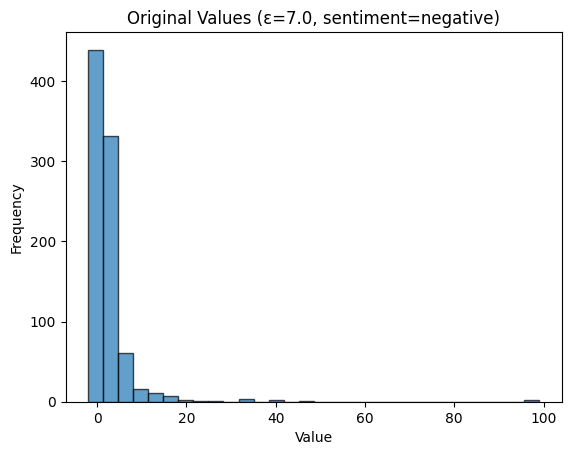

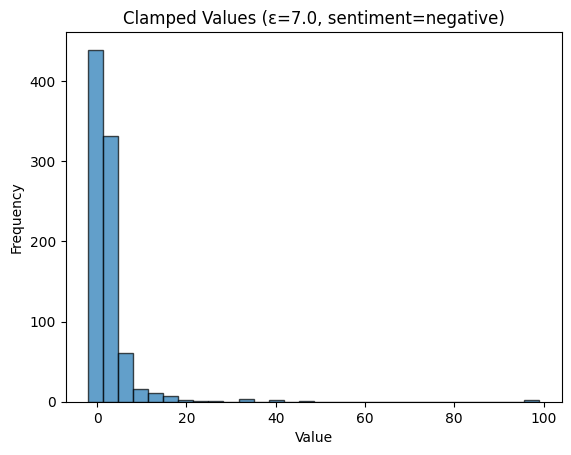

negative :
[('残念', 98.54405901722274), ('部屋', 98.54405901722274), ('少し', 47.54405901722274), ('風呂', 40.54405901722274), ('朝食', 38.54405901722274), ('狭い', 33.54405901722274), ('ある', 32.54405901722274), ('思う', 31.544059017222743), ('ない', 25.544059017222743), ('良い', 23.544059017222743), ('なる', 20.544059017222743), ('悪い', 18.544059017222743), ('食事', 16.544059017222743), ('古い', 15.544059017222741), ('欲しい', 15.544059017222741), ('する', 15.544059017222741), ('食べる', 15.544059017222741), ('露天風呂', 14.544059017222741), ('期待', 14.544059017222741), ('掃除', 13.544059017222741)]
ε:  10.0


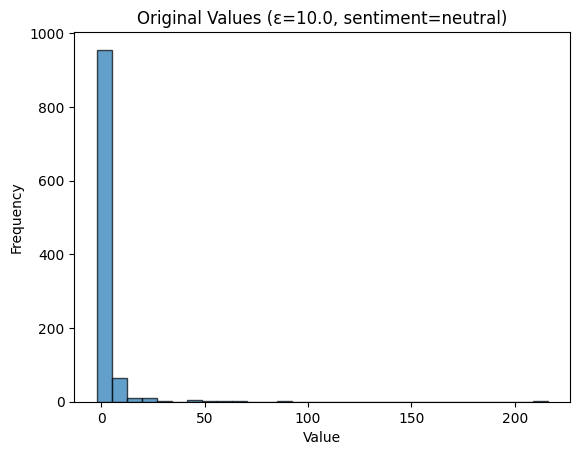

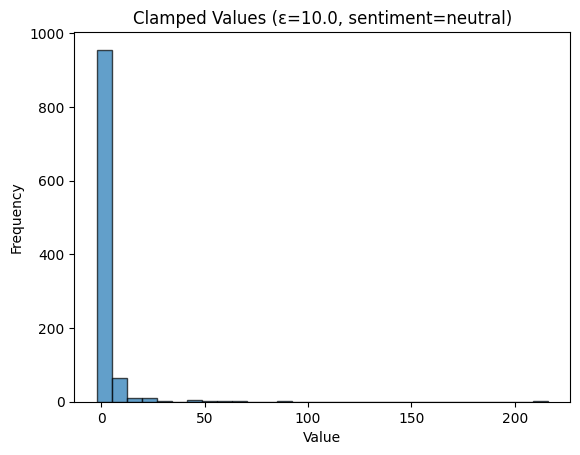

neutral :
[('利用', 215.97730003511876), ('部屋', 91.97730003511876), ('旅行', 67.97730003511876), ('ある', 59.97730003511876), ('思う', 58.97730003511876), ('朝食', 49.97730003511876), ('風呂', 45.97730003511876), ('普通', 44.97730003511876), ('宿泊', 43.97730003511876), ('なる', 42.97730003511876), ('初めて', 33.97730003511876), ('ホテル', 31.97730003511876), ('いる', 30.97730003511876), ('良い', 26.97730003511876), ('感じ', 25.97730003511876), ('出張', 24.97730003511876), ('家族', 24.97730003511876), ('予約', 22.97730003511876), ('する', 21.97730003511876), ('今回', 20.97730003511876)]


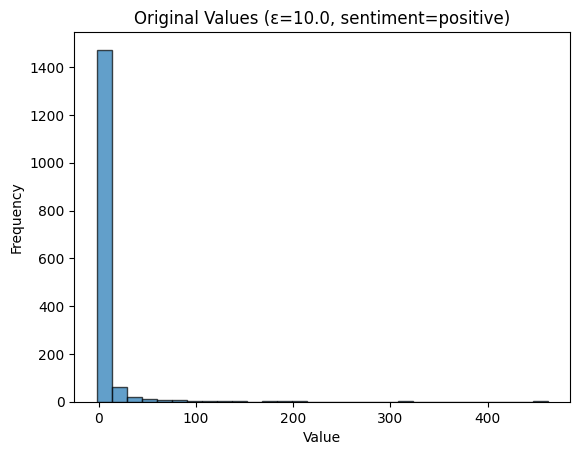

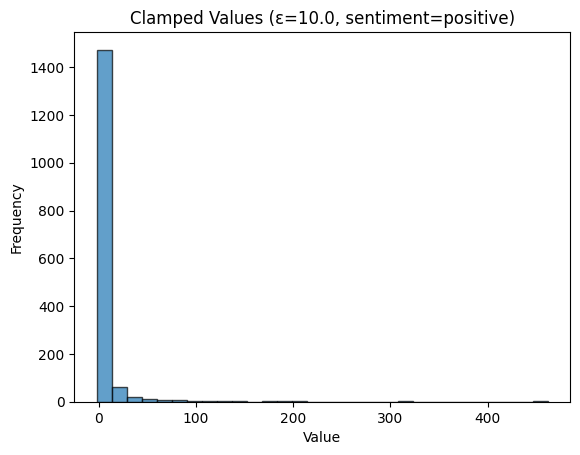

positive :
[('良い', 461.97730003511873), ('部屋', 314.97730003511873), ('美味しい', 205.97730003511876), ('利用', 197.97730003511876), ('満足', 192.97730003511876), ('朝食', 180.97730003511876), ('思う', 174.97730003511876), ('ある', 143.97730003511876), ('風呂', 140.97730003511876), ('最高', 138.97730003511876), ('ホテル', 123.97730003511876), ('対応', 106.97730003511876), ('いる', 101.97730003511876), ('また', 98.97730003511876), ('温泉', 94.97730003511876), ('よい', 92.97730003511876), ('清潔', 88.97730003511876), ('接客', 86.97730003511876), ('綺麗', 84.97730003511876), ('気持ち', 79.97730003511876)]


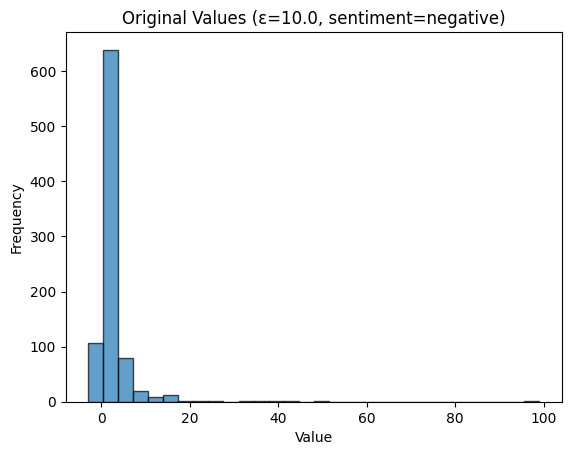

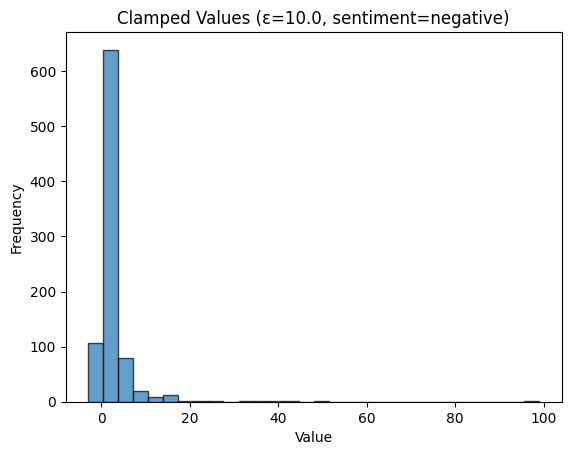

negative :
[('残念', 98.97730003511876), ('部屋', 96.97730003511876), ('少し', 47.97730003511876), ('風呂', 41.97730003511876), ('朝食', 38.97730003511876), ('狭い', 35.97730003511876), ('思う', 33.97730003511876), ('ある', 32.97730003511876), ('ない', 25.97730003511876), ('良い', 22.97730003511876), ('なる', 21.97730003511876), ('悪い', 18.97730003511876), ('欲しい', 15.977300035118757), ('掃除', 15.977300035118757), ('する', 15.977300035118757), ('食事', 15.977300035118757), ('露天風呂', 15.977300035118757), ('食べる', 14.977300035118757), ('古い', 14.977300035118757), ('期待', 13.977300035118757)]


In [66]:
import numpy as np
import matplotlib.pyplot as plt

# クランプ処理
def clamp_values(values: np.ndarray, LAMBDA: float) -> np.ndarray:
    return np.clip(values, -LAMBDA, LAMBDA)

# ヒストグラムを表示する関数
def plot_histogram(values: np.ndarray, title: str):
    plt.hist(values, bins=30, alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# 差分プライバシーの適用
epsilons = [0.01, 0.05, 0.1, 0.3, 0.7, 1.0, 2.0, 3.0, 7.0, 10.0]
MAX_DUPLICATED_TERMS = 1
LAMBDA = 500  # クランプ閾値の設定

# 結果を保存するための辞書を初期化
results = {sentiment: {"no DP": None, **{eps: None for eps in epsilons}} for sentiment in df["sentiment"].unique()}

for eps in epsilons:
    print("ε: ", eps)
    for sentiment in df["sentiment"].unique():
        repeated_words = preprocess_for_private_counts(term_frequencies[sentiment])
        private_counts = cal_private_count(eps, MAX_TERMS_IN_DOC, MAX_DUPLICATED_TERMS, repeated_words)
        
        # 元のデータ値のヒストグラムを表示
        plot_histogram(private_counts, f'Original Values (ε={eps}, sentiment={sentiment})')
        
        # データの値に対するクランプ処理（-LAMBDAからLAMBDAの範囲）
        clamped_counts = clamp_values(private_counts, LAMBDA)
        
        # クランプ後のデータ値のヒストグラムを表示
        plot_histogram(clamped_counts, f'Clamped Values (ε={eps}, sentiment={sentiment})')
        
        # バイアス補正
        bias_corrected_counts = [count - LAMBDA * np.exp(-eps) for count in clamped_counts]
        
        words_and_counts = top_k_words_and_counts(TOP_K, bias_corrected_counts, vocabs[sentiment])
        results[sentiment][eps] = words_and_counts
        print(sentiment, ":")
        print(words_and_counts)

## 6. 結果を表形式で表示


In [67]:
# 差分プライバシーなしの頻度計算を保存
for sentiment in df["sentiment"].unique():
    words_and_counts = top_k_words_and_counts(TOP_K, term_frequencies[sentiment], vocabs[sentiment])
    results[sentiment]["no DP"] = words_and_counts


# 結果を表示する関数
def display_results(results):
    for sentiment, data in results.items():
        print(f"\nSentiment: {sentiment}\n")
        df = pd.DataFrame(columns=["rank", "word", "count"] + [f"ε={eps}" for eps in epsilons])
        for rank, (word, count) in enumerate(data["no DP"], start=1):
            row = {"rank": rank, "word": word, "count": count}
            for eps in epsilons:
                if eps in data and rank <= len(data[eps]):
                    row[f"ε={eps}"] = data[eps][rank-1][1] if rank-1 < len(data[eps]) else None
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        print(df)

display_results(results)



Sentiment: neutral

   rank word count    ε=0.01      ε=0.05       ε=0.1      ε=0.3       ε=0.7  \
0     1   利用   216  4.975083   24.385288  -52.418709 -194.40911  -50.292652   
1     2   部屋    93  4.975083   24.385288 -170.418709 -269.40911 -141.292652   
2     3   旅行    67  4.975083   24.385288 -173.418709 -275.40911 -178.292652   
3     4   ある    60  4.975083  -32.614712 -178.418709 -280.40911 -179.292652   
4     5   思う    59  4.975083  -42.614712 -222.418709 -280.40911 -187.292652   
5     6   朝食    50  4.975083  -57.614712 -223.418709 -283.40911 -190.292652   
6     7   風呂    47  4.975083  -59.614712 -227.418709 -288.40911 -195.292652   
7     8   普通    45  4.975083  -72.614712 -229.418709 -289.40911 -198.292652   
8     9   宿泊    43  4.975083  -91.614712 -238.418709 -290.40911 -203.292652   
9    10   なる    43  4.975083  -92.614712 -243.418709 -290.40911 -205.292652   
10   11  初めて    34  4.975083  -99.614712 -256.418709 -291.40911 -208.292652   
11   12  ホテル    32  4.975083 -1

/tmp/ipykernel_931337/446711119.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_931337/446711119.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_931337/446711119.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA colum

## 7.グラフの生成

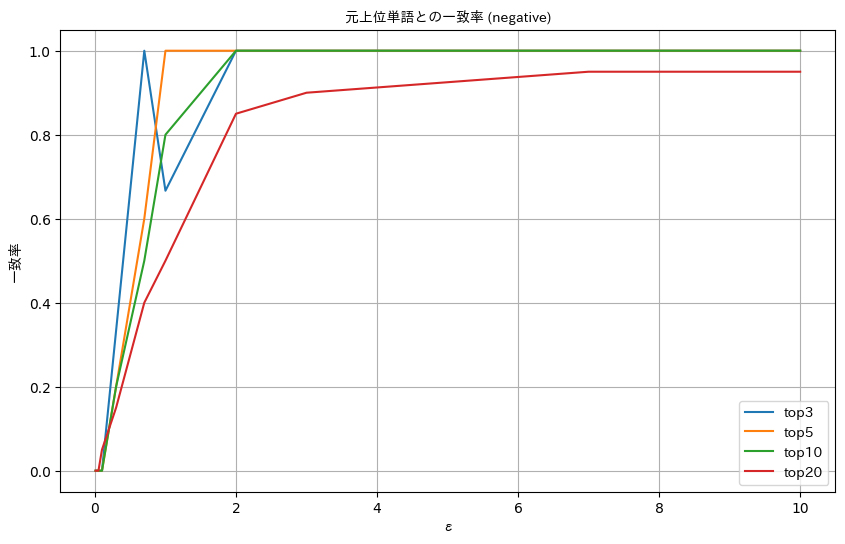

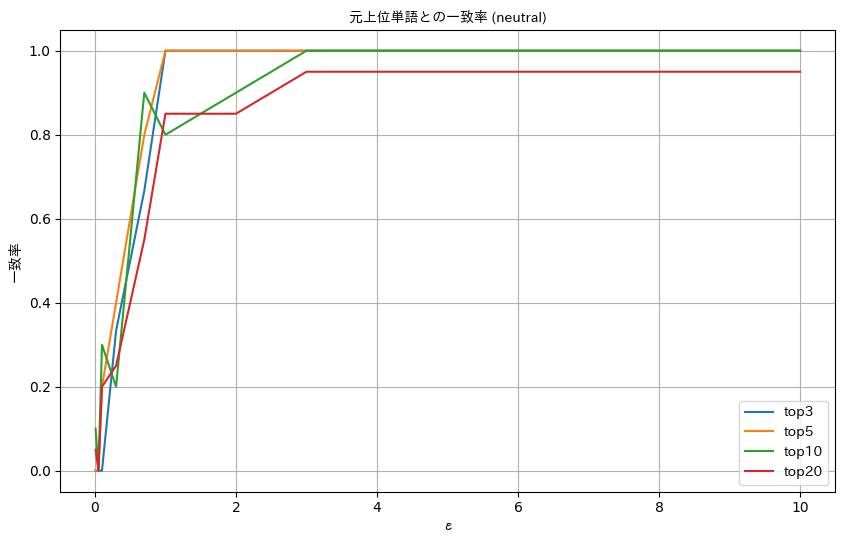

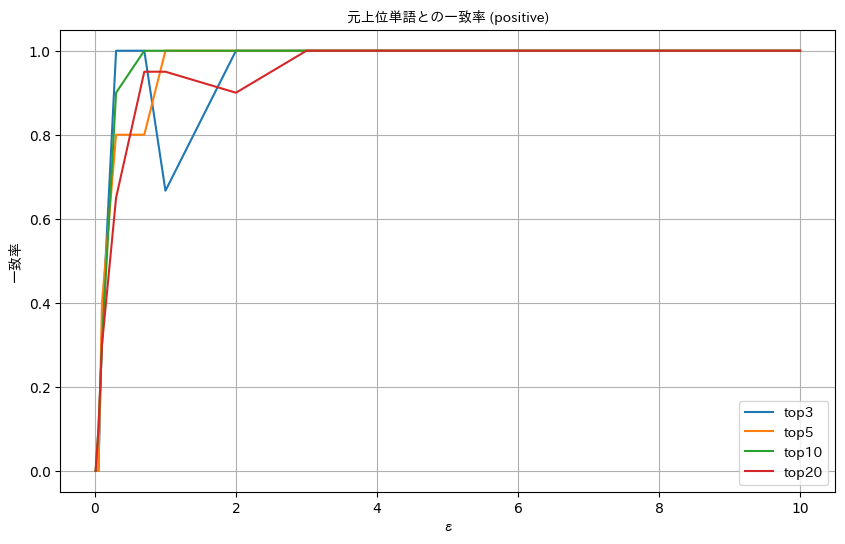

In [68]:
# グラフの生成
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 日本語フォントの設定
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)

def calculate_match_rate(original_top_k, dp_top_k):
    match_count = len(set(original_top_k) & set(dp_top_k))
    return match_count / len(original_top_k) if original_top_k else 0

def plot_match_rate(results, epsilons, sentiment_label):
    top_k_values = [3, 5, 10, 20]
    match_rates = {k: [] for k in top_k_values}

    for eps in epsilons:
        for k in top_k_values:
            original_top_k = [word for word, count in results[sentiment_label]["no DP"][:k]]
            dp_top_k = [word for word, count in results[sentiment_label][eps][:k]]
            match_rate = calculate_match_rate(original_top_k, dp_top_k)
            match_rates[k].append(match_rate)

    plt.figure(figsize=(10, 6))
    for k, rates in match_rates.items():
        plt.plot(epsilons, rates, label=f'top{k}')

    plt.xlabel('ε', fontproperties=font_prop)
    plt.ylabel('一致率', fontproperties=font_prop)
    plt.title(f'元上位単語との一致率 ({sentiment_label})', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)
    plt.show()

epsilons = [0.01, 0.05, 0.1, 0.3, 0.7, 1.0, 2.0, 3.0, 7.0, 10.0]

plot_match_rate(results, epsilons, 'negative')
plot_match_rate(results, epsilons, 'neutral')
plot_match_rate(results, epsilons, 'positive')


